<a href="https://colab.research.google.com/github/onurburakozdemir/AutoML_Google/blob/main/bitirmeSon_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CartPole Problem

## gereksiz makale shit

In [ ]:
import gym
import numpy as np
import random, math
import matplotlib.pyplot as plt
env = gym.make("CartPole-v0")
no_buckets = (1,1,6,3)
no_actions = env.action_space.n
state_value_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_value_bounds[1] = (-0.5, 0.5)
state_value_bounds[3] = (-math.radians(50), math.radians(50))
# define q_value_table - it has a dimension of 1 x 1 x 6 x 3 x 2
q_value_table = np.zeros(no_buckets + (no_actions,))
# user-defined parameters
min_explore_rate = 0.1; min_learning_rate = 0.1; max_episodes = 1000
max_time_steps = 250; streak_to_end = 120; solved_time = 199; discount = 0.99
no_streaks = 0

# Select an action using epsilon-greedy policy
def select_action(state_value, explore_rate): # omitted
    if random.random() < explore_rate:
        action = env.action_space.sample() # explore
    else: # exploit
        action = np.argmax(q_value_table[state_value])
    return action

# change the exploration rate over time.
def select_explore_rate(x):
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/25)))

# Change learning rate over time
def select_learning_rate(x):
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/25)))
    
# Bucketize the state_value
def bucketize(state_value):# omitted
    bucket_indices = []
    for i in range(len(state_value)):
        if state_value[i] <= state_value_bounds[i][0]:
            # violates lower bound
            bucket_index = 0
        elif state_value[i] >= state_value_bounds[i][1]:
        # violates upper bound
        # put in the last bucket
            bucket_index = no_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - \
                state_value_bounds[i][0]
            offset = (no_buckets[i]-1) * \
                state_value_bounds[i][0] / bound_width
            scaling = (no_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state_value[i] -offset))
        bucket_indices.append(bucket_index)
    return(tuple(bucket_indices))

In [ ]:
# train the system
totaltime = 0
for episode_no in range(max_episodes):
    #learning rate and explore rate diminishes
    # monotonically over time
    explore_rate = select_explore_rate(episode_no)
    learning_rate = select_learning_rate(episode_no)
    # initialize the environment
    observation = env.reset()
    start_state_value = bucketize(observation)
    previous_state_value = start_state_value
    done = False
    time_step = 0
    while not done:
      #env.render()
      # select action using epsilon-greedy policy
      action = select_action(previous_state_value, explore_rate)
      # record new observations
      observation, reward_gain, done, info = env.step(action)
      #update q_value_table
      best_q_value = np.max(q_value_table[previous_state_value])
      q_value_table[previous_state_value][action] += learning_rate * (
          reward_gain + discount * best_q_value -
          q_value_table[previous_state_value][action])
      # update the states for next iteration
      state_value = bucketize(observation)
      previous_state_value = state_value
      time_step += 1
      # while loop ends here

    if time_step >= solved_time:
      no_streaks += 1
    else:
      no_streaks = 0
    if no_streaks > streak_to_end:
      print("CartPole problem is solved after {} episodes.", episode_no)
      break
env.close()

##potansiyel vaat eden kod

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')

# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
LEARNING_RATE = 0.1
# Between 0 and 1, mesue of how much we carre about future reward over immedate reward
DISCOUNT = 0.95
RUNS = 10000  # Number of iterations run
SHOW_EVERY = 2000  # How oftern the current solution is rendered
UPDATE_EVERY = 100  # How oftern the current progress is recorded

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = RUNS // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


# Create bins and Q table
def create_bins_and_q_table():
	# env.observation_space.high
	# [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
	# env.observation_space.low
	# [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

	# remove hard coded Values when I know how to

	numBins = 20
	obsSpaceSize = len(env.observation_space.high)

	# Get the size of each bucket
	bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
	]

	qTable = np.random.uniform(low=-2, high=0, size=([numBins] * obsSpaceSize + [env.action_space.n]))

	return bins, obsSpaceSize, qTable


# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)


bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

for run in range(RUNS):
	discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
	done = False  # has the enviroment finished?
	cnt = 0  # how may movements cart has made

	while not done:
		#if run % SHOW_EVERY == 0:
			#env.render()  # if running RL comment this out

		cnt += 1
		# Get action from Q table
		if np.random.random() > epsilon:
			action = np.argmax(qTable[discreteState])
		# Get random action
		else:
			action = np.random.randint(0, env.action_space.n)
		newState, reward, done, _ = env.step(action)  # perform action on enviroment

		newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

		maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
		currentQ = qTable[discreteState + (action, )]  # old value

		# pole fell over / went out of bounds, negative reward
		if done and cnt < 200:
			reward = -375

		# formula to caculate all Q values
		newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
		qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

		discreteState = newDiscreteState

	previousCnt.append(cnt)

	# Decaying is being done every run if run number is within decaying range
	if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
		epsilon -= epsilon_decay_value

	# Add new metrics for graph
	if run % UPDATE_EVERY == 0:
		latestRuns = previousCnt[-UPDATE_EVERY:]
		averageCnt = sum(latestRuns) / len(latestRuns)
		metrics['ep'].append(run)
		metrics['avg'].append(averageCnt)
		metrics['min'].append(min(latestRuns))
		metrics['max'].append(max(latestRuns))
		print("Run:", run, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))


env.close()

# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)
plt.show()

##Potansiyel vaat eden kod editlenmiş


In [ ]:
#@title library taslak
import gym
from gym import spaces

class CustomEnvironment(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, df):
    super(CustomEnv, self).__init__()    # Define action and observation space
    # They must be gym.spaces objects    # Example when using discrete actions:
    self.df = df
    self.reward_range = (0, 2)
    self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([1, 1]), dtype=np.float16)
    self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([200, 200]), dtype=np.float16)

  def step(self, action):
    # Execute one time step within the environment
    def reset(self):
    # Reset the state of the environment to an initial state
      self.ozon = 60
      self.debi = 45
      self.max_net_worth = INITIAL_ACCOUNT_BALANCE
      self.shares_held = 0
      self.cost_basis = 0
      self.total_shares_sold = 0
      self.total_sales_value = 0
    ...  def render(self, mode='human', close=False):
    # Render the environment to the screen
    ...

###Import ve library


In [40]:
#@title EnvLibrary
import math
from typing import Optional

import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class OzonEnv(gym.Env):

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self):
        self.ozon = 20
        self.debi = 20

        # Threshold at which to fail the episode
        self.ozon_threshold = 50
        self.debi_threshold = 10

        # limit is set to 2 * ozon_threshold so failing observation
        # is still within bounds.
        high = np.array([self.debi_threshold*2,self.ozon_threshold*2],dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=np.array([0.0, 0.0]), high=np.array([100, 100]), dtype=np.float32)

        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        debi, ozon = self.state

        if action == 1:
            debi = debi - debi/2
            ozon = ozon + self.ozon/2
            
        else:  
            debi = debi + debi/2
            ozon = ozon - self.ozon/2

        self.state = (debi, ozon)

        done = bool(
            debi < self.debi_threshold
            or ozon > self.ozon_threshold
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state, dtype=np.float32), reward, done, {}

    def reset(self):
        self.state = np.random.uniform(low=20, high=30, size=(2,))
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [1]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time

In [7]:
def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(0,1,bin_size),
            np.linspace(0,1,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

In [5]:
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 5000, epsilon = 0.2):
    rewards = 0
    solved = False 
    steps = 0 
    runs = [0]
    data = {'max' : [0], 'avg' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1,timestep)] 
    
    for episode in range(1,episodes+1):
        
        current_state = Discrete(env.reset(),bins) # initial observation
        score = 0
        done = False
        temp_start = time.time()
        
        while not done:
            steps += 1 
            ep_start = time.time()
                
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            
            observation, reward, done, info = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward
            

            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            if score > 195 and steps >= 100 and solved == False: # considered as a solved:
                solved = True
                print('Solved in episode : {} in time {}'.format(episode, (time.time()-ep_start)))
        
        # Timestep value update
        if episode%timestep == 0:
            print('Episode : {} | Reward -> {} | Max reward : {} | Time : {}'.format(episode,rewards/timestep, max(runs), time.time() - ep_start))
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            if rewards/timestep >= 195: 
                print('Solved in episode : {}'.format(episode))
            rewards, runs= 0, [0] 
            
    if len(ep) == len(data['max']):
        plt.plot(ep, data['max'], label = 'Max')
        plt.plot(ep, data['avg'], label = 'Avg')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc = "upper left")
        
    env.close()

Episode : 1000 | Reward -> 41.976 | Max reward : 178.0 | Time : 0.00010895729064941406
Episode : 2000 | Reward -> 78.333 | Max reward : 190.0 | Time : 9.1552734375e-05
Solved in episode : 2149 in time 6.270408630371094e-05
Episode : 3000 | Reward -> 109.986 | Max reward : 200.0 | Time : 8.893013000488281e-05
Episode : 4000 | Reward -> 124.924 | Max reward : 200.0 | Time : 0.000118255615234375
Episode : 5000 | Reward -> 132.871 | Max reward : 200.0 | Time : 9.989738464355469e-05


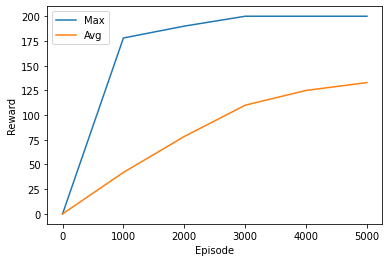

In [6]:
# TRANING
q_table, bins = Qtable(len(env.observation_space.low), env.action_space.n)

Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5*10**3, timestep = 1000)

## RJBrooker


In [ ]:
%%bash
git clone https://github.com/openai/gym.git
cd gym
pip install -e .
pip uninstall pyglet
pip install pyglet==1.2.4

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
import time, math, random
from typing import Tuple

# import gym 
import gym

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
policy = lambda obs: 1

for _ in range(3):
    obs = env.reset()
    for _ in range(80):
        actions = policy(obs)
        obs, reward, done, info = env.step(actions) 
env.close()


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
?env.env

In [ ]:
#Simple policy function 
policy = lambda _,__,___, tip_velocity : int( tip_velocity > 0 )

In [ ]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

In [ ]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(6, 12, 2)

In [ ]:
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])

In [ ]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In [ ]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

In [ ]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [ ]:
n_episodes = 10000 
for e in range(n_episodes):
    
    # Siscretize state into buckets
    current_state, done = discretizer(*env.reset()), False
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment
        obs, reward, done, _ = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state

KeyboardInterrupt: ignored

# Basit Q-Learning

In [1]:
#@title importlar
import numpy as np
import pandas as pd
import time
from random import choice
import matplotlib.pyplot as plt
np.random.seed(2)

### Parametreler

In [11]:
n_states = 21
middle = n_states // 2
actions = ["filtre kapa","filtre ac"]

eps = 0.9
alpha = 0.1
gamma = 0.9

max_episode = 20
fresh_time = 0.3

In [3]:
#@title Q-Table
def build_q_table(n_states,actions):
  table = pd.DataFrame(np.zeros((n_states,len(actions))),columns = actions)
  return table

### Action seçme

In [4]:
def choose_action(state,q_table):
  state_actions = q_table.iloc[state,:]
  if (np.random.uniform() > eps) or (state_actions==0).all():
    action_name = np.random.choice(actions)

  else: 
    action_name = state_actions.idxmax()
  print("action name: ",action_name)
  return action_name

### Env feedback alma

In [5]:
def get_env_feedback(S,A):
  if A=="filtre ac":
    if S == middle:
      S_ = "terminal"
      R = 1
    elif S == n_states - 1:
      S_ = S 
      R = 0
    else:
      S_ = S+1
      R = 0
  else:
    if S == middle:
      S_ = "terminal"
      R = 1
    elif S == 0:
      S_ = S
      R = 0
    else: 
      S_ = S-1
      R = 0
  return S_ , R

### Env Update

In [6]:
def update_env(S,episode,step_counter):
  env_list = ["0"]*middle + ["X"] + ["0"]*middle
  if S == "terminal":
    interaction = "episode is %s, total_steps = %s" %(episode+1,step_counter)
    print("\r{}" .format(interaction),end=" ")
    time.sleep(2)
    print("\r                            ",end=" ")
  else:
    env_list[S]= "B"
    interaction = "".join(env_list)
    print("\r{}".format(interaction),end=" ")
    time.sleep(fresh_time)

### RL Loop

In [12]:
def rl():
  stepler = []
  episodelar = np.arange(1, max_episode+1, 1)
  q_table = build_q_table(n_states,actions)
  for episode in range(max_episode):
    step_counter = 0
    S = choice([i for i in range(n_states) if i not in [middle]]) #baslangic state'i
    is_terminal = False
    update_env(S,episode,step_counter)
    while not is_terminal:
      A = choose_action(S,q_table)
      S_, R = get_env_feedback(S,A)
      q_predict = q_table.loc[S,A]
      if S_ != "terminal":
        q_target = R + gamma * q_table.iloc[S_,:].max() 
      else:
        q_target = R
        is_terminal = True
      q_table.loc[S,A] += alpha*(q_target-q_predict)
      S = S_
      step_counter +=1
      update_env(S,episode,step_counter)
    stepler.append(step_counter)

  #plotting
  plt.plot(episodelar,stepler,"b")
  plt.xlabel("episode")
  plt.ylabel("number of step")
  plt.title('episode sayısına bağlı öğrenme')
  plt.show()

  return q_table

### Eğitme

000000B000X0000000000 action name:  sol
00000B0000X0000000000 action name:  sag
000000B000X0000000000 action name:  sag
0000000B00X0000000000 action name:  sol
000000B000X0000000000 action name:  sol
00000B0000X0000000000 action name:  sol
0000B00000X0000000000 action name:  sag
00000B0000X0000000000 action name:  sol
0000B00000X0000000000 action name:  sag
00000B0000X0000000000 action name:  sag
000000B000X0000000000 action name:  sag
0000000B00X0000000000 action name:  sol
000000B000X0000000000 action name:  sol
00000B0000X0000000000 action name:  sol
0000B00000X0000000000 action name:  sol
000B000000X0000000000 action name:  sag
0000B00000X0000000000 action name:  sol
000B000000X0000000000 action name:  sag
0000B00000X0000000000 action name:  sag
00000B0000X0000000000 action name:  sag
000000B000X0000000000 action name:  sag
0000000B00X0000000000 action name:  sol
000000B000X0000000000 action name:  sag
0000000B00X0000000000 action name:  sol
000000B000X0000000000 action name:  sag


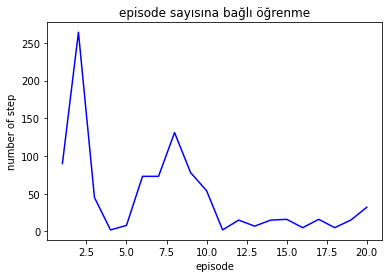


Game:

             sol           sag
0   0.000000e+00  0.000000e+00
1   0.000000e+00  0.000000e+00
2   0.000000e+00  0.000000e+00
3   0.000000e+00  4.016737e-08
4   0.000000e+00  3.784209e-06
5   0.000000e+00  1.064979e-04
6   0.000000e+00  1.569883e-03
7   2.609966e-06  1.489853e-02
8   0.000000e+00  9.448631e-02
9   0.000000e+00  3.746590e-01
10  1.000000e-01  8.649148e-01
11  3.615250e-01  0.000000e+00
12  9.371948e-02  0.000000e+00
13  1.596209e-02  6.940679e-06
14  1.876724e-03  0.000000e+00
15  1.207017e-04  0.000000e+00
16  3.935062e-06  0.000000e+00
17  1.440525e-07  0.000000e+00
18  2.638764e-09  0.000000e+00
19  0.000000e+00  0.000000e+00
20  0.000000e+00  0.000000e+00


In [13]:
game = rl()
print("\r\nGame:\n")
print(game)

In [15]:
choose_action(4,game)

action name:  sag


'sag'